In [19]:
import numpy as np
import pandas as pd
from scipy.ndimage.measurements import label as label_region
from scipy.ndimage.measurements import find_objects
import matplotlib.pyplot as plt
import seaborn as sns
pal = sns.color_palette('pastel')


In [4]:
df = pd.read_csv('../data/out/Belling_climate_modes_glacier.csv', sep='\t', index_col=['time'], parse_dates=['time'])
df

,SAM,NINO3.4,PDO,SOI,T2,PDD,SF,SMB,MELT,Q,RZ
time,,,,,,,,,,,
1959-01-01,1.59,0.52,1.04,-1.5,-0.330943,5.565953,0.028780,-0.048413,0.077192,0.068192,0.014937
1959-02-01,-0.19,0.44,0.35,-2.3,-1.063417,0.915968,0.038195,0.025492,0.012703,0.005515,0.019742
1959-03-01,-0.54,0.24,-0.14,2.1,-1.360896,3.505931,0.060583,0.011961,0.048623,0.029746,0.031253
1959-04-01,-1.25,0.17,-0.16,0.7,-6.059883,0.000000,0.037331,0.037331,0.000000,0.000000,0.018730
1959-05-01,-0.32,-0.11,-0.13,0.8,-5.209905,0.010123,0.066319,0.066179,0.000140,0.000000,0.033447
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,-2.20,-0.57,-1.32,1.8,-7.341003,0.408967,0.089383,0.083711,0.005672,0.000000,0.044506
2020-09-01,-0.25,-0.84,-1.04,1.5,-5.275930,0.006578,0.082930,0.082839,0.000091,0.000000,0.041806
2020-10-01,1.79,-1.21,-0.62,0.8,-3.201353,0.003562,0.090194,0.090144,0.000049,0.000000,0.046026


In [13]:
window = 10
dfm_SAM = df[['SAM']].rolling(window=window, center=True, min_periods=1).mean()
window = 5
dfm_ENSO = df[['NINO3.4']].rolling(window=window, center=True, min_periods=1).mean()

In [15]:
thres = 0.5
r, nr = label_region(df['NINO3.4'] > thres)
nr = [i+1 for i, o in enumerate(find_objects(r)) if (len(r[o]) >= 6)]
is_nino = [ri in nr for ri in r]

r, nr = label_region(df['NINO3.4'] < (-thres))
nr = [i+1 for i, o in enumerate(find_objects(r)) if (len(r[o]) >= 6)]
is_nina = [ri in nr for ri in r]

df['is_nina'] = is_nina
df['is_nino'] = is_nino
df['is_neutral'] = ~(df['is_nina'] | df['is_nino'])

nx = len(df['NINO3.4'])
xtime = np.arange(nx)
tspans = np.linspace(0, nx, nx*2+1)
isnino = np.interp(tspans, xtime, df['is_nino'].values.astype(float)) != 0
isnina = np.interp(tspans, xtime, df['is_nina'].values.astype(float)) != 0

In [17]:
majorTickNames = np.arange(13)*5 + 1960
majorTickNames
majorTickPos = np.array([])
for y in majorTickNames:
    majorTickPos = np.append(majorTickPos, np.where((dfm_SAM.index.month == 1) &
                                                    (dfm_SAM.index.year == y))[0])
majorTickPos

array([ 12.,  72., 132., 192., 252., 312., 372., 432., 492., 552., 612.,
       672., 732.])

In [16]:
minorTickNames = np.arange(1960, 2021, 1)
minorTickPos = np.array([])
for y in minorTickNames:
    minorTickPos = np.append(minorTickPos, np.where((dfm_SAM.index.month == 1) &
                                                    (dfm_SAM.index.year == y))[0])

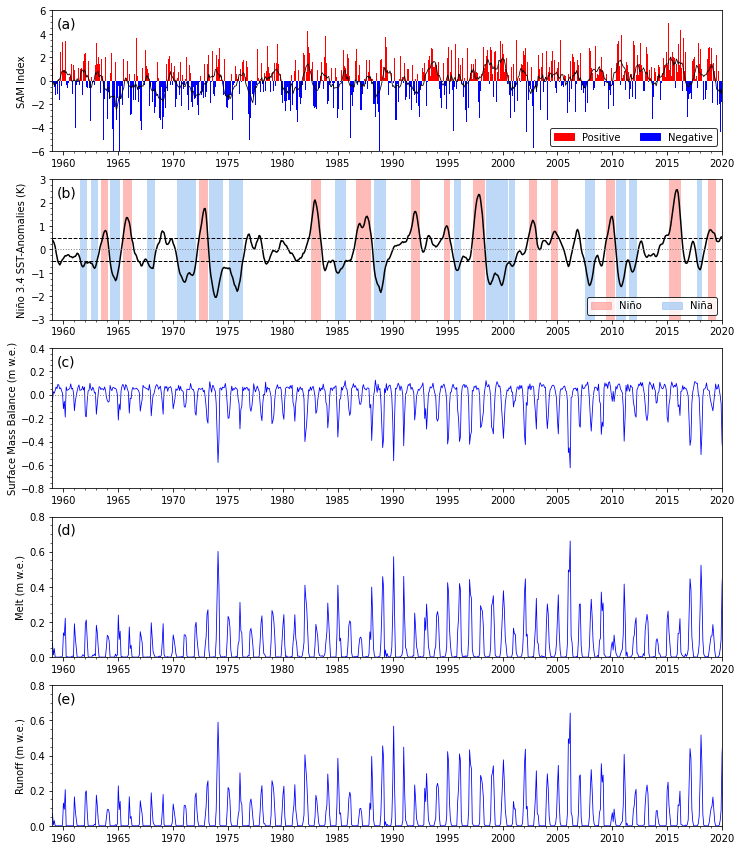

In [24]:
fig = plt.figure(figsize=(12, 15))

ax = fig.add_subplot(511)
plt.plot(xtime, dfm_SAM['SAM'], color='k', linewidth=0.8)
# Create a list of colors based on the color bar values
colors = ['red' if (value > 0) else 'blue' for value in df['SAM'].values]
plt.bar(xtime, 
        df['SAM'].values,
        align='edge',
        edgecolor='none',
        color=colors,
        width=12 / 12,
        linewidth=.3)
plt.ylim([-6,6])
plt.xlim([0, majorTickPos[-1]])
from matplotlib.ticker import AutoMinorLocator
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.xaxis.set_ticks(majorTickPos)
ax.xaxis.set_ticks(minorTickPos, minor=True)
ax.set_xticklabels(majorTickNames)

import matplotlib.patches as mpatches
pat1 = mpatches.Patch(color='red', label=u'Positive')
pat2 = mpatches.Patch(color='blue', label=u'Negative')
import matplotlib as mpl
mpl.rcParams['legend.frameon'] = 'True'
legend = plt.legend(handles=[pat1,pat2], loc='lower right', ncol=2)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
frame.set_linewidth(1)
ax.set_ylabel(u'SAM Index') 
ax.text(5, 4.5,'(a)', fontsize=14)


ax = fig.add_subplot(512)
plt.plot(xtime, dfm_ENSO['NINO3.4'], color='k')
plt.ylim([-3.0,3.0])
plt.xlim([0, majorTickPos[-1]])

from matplotlib.ticker import AutoMinorLocator
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.xaxis.set_ticks(majorTickPos)
ax.xaxis.set_ticks(minorTickPos, minor=True)
ax.set_xticklabels(majorTickNames)

import matplotlib.collections as collections
span_where = collections.BrokenBarHCollection.span_where
c = span_where(tspans, ymin=-3.0, ymax=3.0, where=isnino, color=pal[3], alpha=0.7, linewidths=0)
ax.add_collection(c)
c = span_where(tspans, ymin=-3.0, ymax=3.0, where=isnina, color=pal[0], alpha=0.7, linewidths=0)
ax.add_collection(c)

plt.axhline(0, linewidth=1, color='grey', linestyle =':')
plt.axhline(0.5, linewidth=1, color='k', linestyle ='--')
plt.axhline(-0.5, linewidth=1, color='k', linestyle ='--')

import matplotlib.patches as mpatches
pat1 = mpatches.Patch(color=pal[3], alpha=0.7, label=u'Niño')
pat2 = mpatches.Patch(color=pal[0], alpha=0.7, label=u'Niña')
import matplotlib as mpl
mpl.rcParams['legend.frameon'] = 'True'
legend = plt.legend(handles=[pat1,pat2], loc='lower right', ncol=2)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
frame.set_linewidth(1)
ax.set_ylabel(u'Niño 3.4 SST-Anomalies (K)') 
ax.text(5, 2.25,'(b)', fontsize=14)

ax = fig.add_subplot(513)

plt.plot(xtime, df['SMB'], color='b', linewidth=0.8)
plt.axhline(0, linewidth=1, color='grey', linestyle =':')
plt.ylim([-0.8,0.4])
plt.xlim([0, majorTickPos[-1]])
from matplotlib.ticker import AutoMinorLocator
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.xaxis.set_ticks(majorTickPos)
ax.xaxis.set_ticks(minorTickPos, minor=True)
ax.set_xticklabels(majorTickNames)
ax.set_ylabel(u'Surface Mass Balance (m w.e.)') 
ax.text(5, 0.25,'(c)', fontsize=14)

ax = fig.add_subplot(514)

plt.plot(xtime, df['MELT'], color='b', linewidth=0.8)
plt.ylim([0,0.8])
plt.xlim([0, majorTickPos[-1]])
from matplotlib.ticker import AutoMinorLocator
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.xaxis.set_ticks(majorTickPos)
ax.xaxis.set_ticks(minorTickPos, minor=True)
ax.set_xticklabels(majorTickNames)
ax.set_ylabel(u'Melt (m w.e.)') 
ax.text(5, 0.7,'(d)', fontsize=14)

ax = fig.add_subplot(515)

plt.plot(xtime, df['Q'], color='b', linewidth=0.8)
plt.ylim([0,0.8])
plt.xlim([0, majorTickPos[-1]])
from matplotlib.ticker import AutoMinorLocator
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.xaxis.set_ticks(majorTickPos)
ax.xaxis.set_ticks(minorTickPos, minor=True)
ax.set_xticklabels(majorTickNames)
ax.set_ylabel(u'Runoff (m w.e.)')
ax.text(5, 0.7,'(e)', fontsize=14)

fig.savefig('../fig/MC_Glac_1960-2020.pdf',dpi = 200, bbox_inches = 'tight', 
            pad_inches = 0.1, facecolor='w')

#import subprocess
#subprocess.call('inkscape ../fig/MC_Glac_1960-2020.svg -M ../fig/MC_Glac_1960-2020.wmf',shell=True)